# Aaisha Siddiqah

#Fraud Transaction Detection Using Transactions Dataset

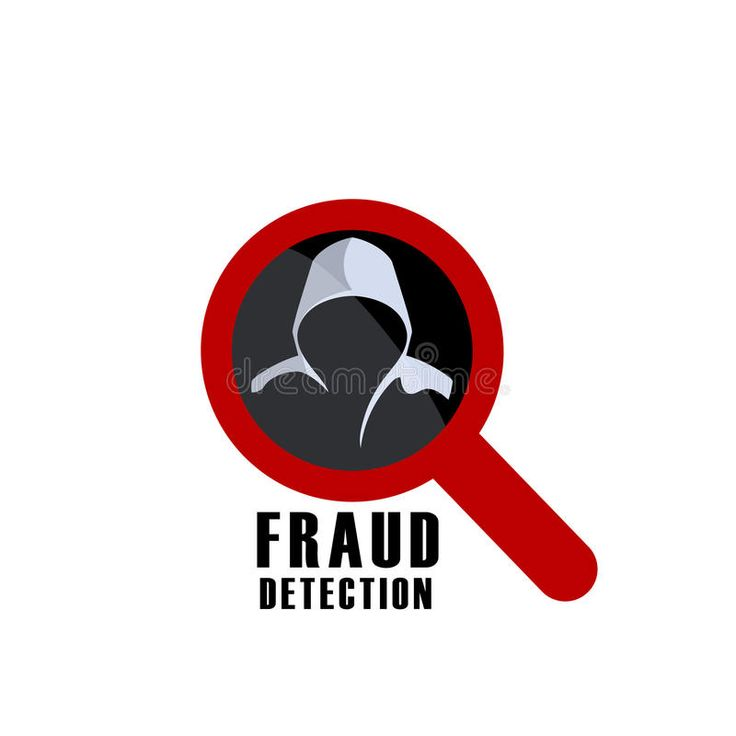

Objective:

Build a system that can classify if a transaction is fraudulent or not.

Dataset:

This dataset is a simulated dataset of original and fraudulent transactions, and only has the main core details of a transaction.

The simulated frauds are using the following scenarios:

1. Any transaction whose amount is more than 220 is a fraud. This is not inspired by a real-world scenario. It provides an obvious fraud pattern that should be detected by any baseline fraud detector

2. Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. You could add features that keep track of the number of fraudulent transactions on the terminal to help with this scenario.

3. Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. You could add features that keep track of the spending habits of the customer for this scenario.

The Fraud labels for the transactions have been simulated with the above conditions. Please take note of this as it will help you evaluate and diagnose your performance.

Description of main columns:

● TRANSACTION_ID: A unique identifier for the transaction

● TX_DATETIME: Date and time at which the transaction occurs

● CUSTOMER_ID: The identifier for the customer. Each customer has a unique identifier

● TERMINAL_ID: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier

● TX_AMOUNT: The amount of the transaction.

● TX_FRAUD: A binary variable, with the value 0 for a legitimate transaction, 1 for a fraudulent transaction.

# Load and Explore the Data

In [ ]:
#Start by loading and exploring the dataset:

import pandas as pd

df = pd.read_csv("fraud_transactions_dataset.csv")
print(df.head())
print(df.info())
print(df['TX_FRAUD'].value_counts())


   TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0               0  2018-04-01 00:00:31        596.0       3156.0      57.16   
1               1  2018-04-01 00:02:10       4961.0       3412.0      81.51   
2               2  2018-04-01 00:07:56          2.0       1365.0     146.00   
3               3  2018-04-01 00:09:29       4128.0       8737.0      64.49   
4               4  2018-04-01 00:10:34        927.0       9906.0      50.99   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0             31.0           0.0       0.0                0.0  
1            130.0           0.0       0.0                0.0  
2            476.0           0.0       0.0                0.0  
3            569.0           0.0       0.0                0.0  
4            634.0           0.0       0.0                0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515380 entries, 0 to 515379
Data columns (total 9 columns):
 #   Column             Non-Nul

In [ ]:
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'], errors='coerce')

In [ ]:
df = df.dropna(subset=['TX_DATETIME'])

In [ ]:
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'], format='mixed', errors='coerce')

In [ ]:
invalid_dates = df[~df['TX_DATETIME'].astype(str).str.match(r'^\d{4}-\d{2}-\d{2}')]
print(invalid_dates.head())

Empty DataFrame
Columns: [TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, TX_FRAUD, TX_FRAUD_SCENARIO]
Index: []


# Feature Engineering

Creating powerful features for your model:

A. Time-Based Features

In [ ]:
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['HOUR'] = df['TX_DATETIME'].dt.hour
df['DAY'] = df['TX_DATETIME'].dt.day
df['WEEKDAY'] = df['TX_DATETIME'].dt.weekday

B. Terminal Fraud History

In [ ]:
terminal_fraud = df.groupby('TERMINAL_ID')['TX_FRAUD'].rolling(window=28, min_periods=1).sum().reset_index(0, drop=True)
df['TERMINAL_FRAUD_28DAYS'] = terminal_fraud

C. Customer Spending Behavior

In [ ]:
df['CUSTOMER_SPEND_MEAN_7D'] = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['AMOUNT_DIFF'] = df['TX_AMOUNT'] - df['CUSTOMER_SPEND_MEAN_7D']

Modeling - Using any baseline model like Random Forest or XGBoost:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['TX_AMOUNT', 'HOUR', 'WEEKDAY', 'TERMINAL_FRAUD_28DAYS', 'CUSTOMER_SPEND_MEAN_7D', 'AMOUNT_DIFF']].fillna(0)
y = df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    102328
         1.0       0.85      0.77      0.81       748

    accuracy                           1.00    103076
   macro avg       0.92      0.89      0.90    103076
weighted avg       1.00      1.00      1.00    103076



Classification Report

Classification Report:
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00    102328
       Fraud       0.85      0.77      0.81       748

    accuracy                           1.00    103076
   macro avg       0.92      0.89      0.90    103076
weighted avg       1.00      1.00      1.00    103076



<Figure size 600x400 with 0 Axes>

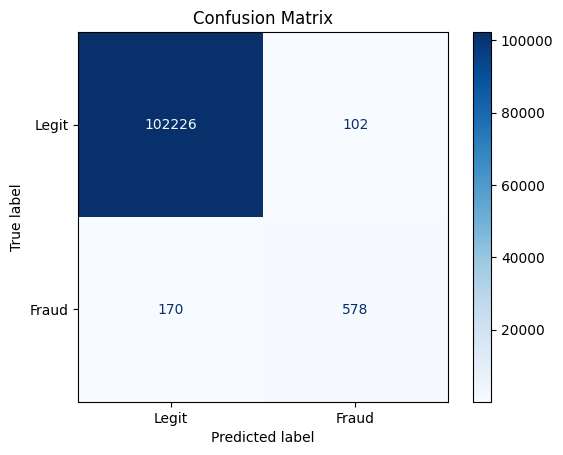

In [ ]:
"""Recall for "Fraud": This shows how many frauds were correctly caught.
Formula: TP / (TP + FN)
High recall = fewer frauds missed
Precision for "Fraud": How many predicted frauds were actually fraud.
F1-score: Balance between precision and recall.
Confusion Matrix layout:"""

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Classification Report (includes Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Legit", "Fraud"]))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Fraud"])

# 3. Plot the Confusion Matrix
plt.figure(figsize=(6,4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target
features = ['TX_AMOUNT']  # Start simple; you can add more features like CUSTOMER_ID patterns, etc.
X = df[features]
y = df['TX_FRAUD']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression

Logistic Regression:
              precision    recall  f1-score   support

       Legit       0.99      1.00      1.00    102326
       Fraud       1.00      0.12      0.21       750

    accuracy                           0.99    103076
   macro avg       1.00      0.56      0.61    103076
weighted avg       0.99      0.99      0.99    103076



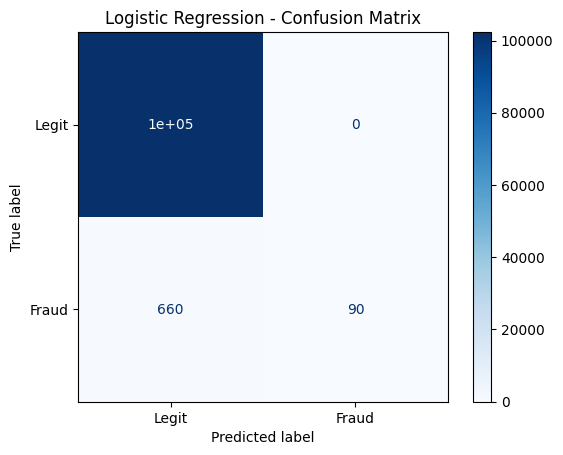

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log, target_names=["Legit", "Fraud"]))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log), display_labels=["Legit", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()


Random Forest

Random Forest:
              precision    recall  f1-score   support

       Legit       0.99      1.00      1.00    102326
       Fraud       0.91      0.26      0.40       750

    accuracy                           0.99    103076
   macro avg       0.95      0.63      0.70    103076
weighted avg       0.99      0.99      0.99    103076



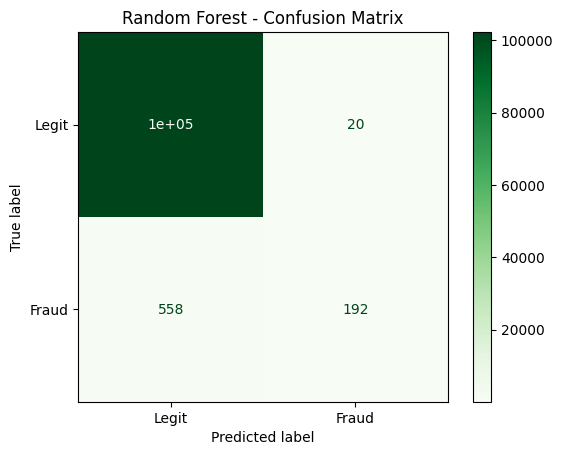

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Random Forest doesn't need scaling

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["Legit", "Fraud"]))

# Confusion Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=["Legit", "Fraud"])
disp_rf.plot(cmap=plt.cm.Greens)
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.show()
